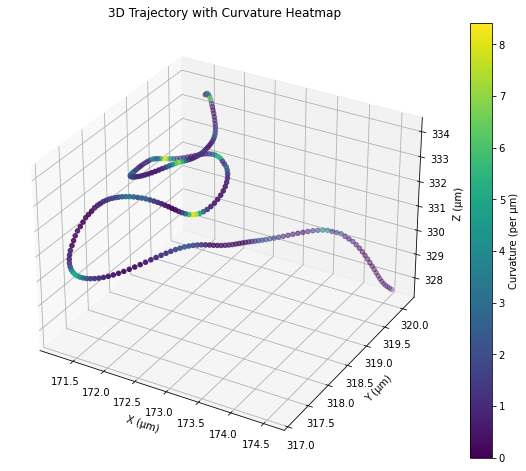

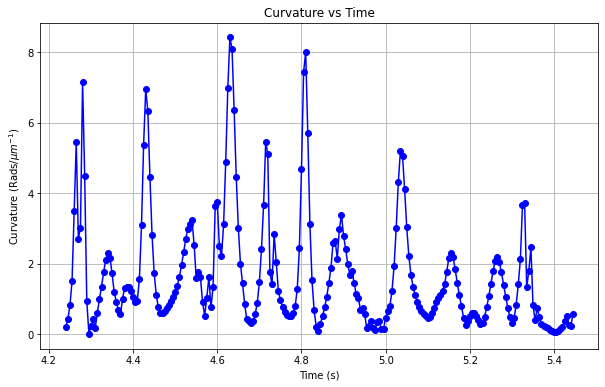

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Necessary for 3D plotting

def calc_curvature_frenet(file_path):
    # Read the file (assumed whitespace-delimited) with columns:
    # time, x, y, z, x_smooth, y_smooth, z_smooth
    data = pd.read_csv(file_path, delim_whitespace=True, header=None, 
                       names=['time', 'x', 'y', 'z', 'x_smooth', 'y_smooth', 'z_smooth'])
    
    # Use the smooth columns for curvature calculation
    time = data['time'].to_numpy()
    x = data['x_smooth'].to_numpy()
    y = data['y_smooth'].to_numpy()
    z = data['z_smooth'].to_numpy()
    
    # Build the position vector array: shape (N, 3)
    r = np.vstack((x, y, z)).T
    N = len(time)
    
    if N < 5:
        # Need at least 5 points to compute central differences twice.
        return np.array([]), np.array([]), r
    
    # --- Step 1: Compute the unit tangent vector T ---
    # T[i] = (r[i+1] - r[i-1]) / ||r[i+1] - r[i-1]||
    r_next = r[2:]      # indices 2 to N-1
    r_prev = r[:-2]     # indices 0 to N-3
    dr = r_next - r_prev         # shape (N-2, 3)
    dt_full = time[2:] - time[:-2]  # time differences for these intervals
    norm_dr = np.linalg.norm(dr, axis=1)
    T = dr / norm_dr[:, None]     # Unit tangent vectors; shape (N-2, 3)
    
    # Compute speed v at points corresponding to T.
    v = norm_dr / dt_full          # Array of speeds; length (N-2)
    
    # Valid times for T: central times (indices 1 to N-2)
    t_T = time[1:-1]
    
    # --- Step 2: Compute the derivative dT/dt ---
    # Using central differences on T: dT/dt at index i (of T) = (T[i+1] - T[i-1]) / (t[i+1] - t[i-1])
    dT = T[2:] - T[:-2]         # shape (N-4, 3)
    dt_T = t_T[2:] - t_T[:-2]    # corresponding time differences; length (N-4)
    dT_dt = dT / dt_T[:, None]   # derivative of T with respect to time; shape (N-4, 3)
    
    # --- Step 3: Compute curvature ---
    # Curvature: kappa = ||dT/dt|| / v, aligning indices:
    # dT_dt corresponds to T indices 1 to (N-3) which correspond to v indices 1 to (N-3)
    curvature = np.linalg.norm(dT_dt, axis=1) / v[1:-1]
    # Times associated with curvature values:
    t_curvature = t_T[1:-1]
    
    return curvature, t_curvature, r

# Example usage:
file_path = 'FINALDATA/Grad_split/swimmers/WTS/WTS_track10057_0_processed.txt'
curvature_array, times, positions = calc_curvature_frenet(file_path)

# Replace NaNs in the curvature array with the mean of the valid (non-NaN) curvature values
if curvature_array.size > 0:
    mean_curvature = np.nanmean(curvature_array)
    curvature_array = np.where(np.isnan(curvature_array), mean_curvature, curvature_array)

# Extract positions corresponding to the curvature values.
# Our curvature is computed from the "central" positions: indices 2 to N-2.
positions_valid = positions[2:-2]

# --- Plotting the 3D trajectory with curvature as a heatmap ---
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Create scatter plot, coloring points by curvature (using a colormap)
sc = ax.scatter(positions_valid[:, 0], positions_valid[:, 1], positions_valid[:, 2], 
                c=curvature_array, cmap='viridis', marker='o')

ax.set_xlabel('X (µm)')
ax.set_ylabel('Y (µm)')
ax.set_zlabel('Z (µm)')
ax.set_title('3D Trajectory with Curvature Heatmap')
fig.colorbar(sc, ax=ax, label='Curvature (per µm)')

plt.show()


# Define the file path (adjust as needed)

# Replace NaNs in the curvature array with the mean of the non-NaN values
if curvature_array.size > 0:
    mean_curvature = np.nanmean(curvature_array)
    curvature_array = np.where(np.isnan(curvature_array), mean_curvature, curvature_array)

# Plot curvature versus time
plt.figure(figsize=(10, 6))
plt.plot(times, curvature_array, marker='o', linestyle='-', color='b')
plt.xlabel('Time (s)')
plt.ylabel('Curvature (Rads/$\mu m^{-1}$)')
plt.title('Curvature vs Time')
plt.grid(True)
plt.savefig('curavture_example.png')
plt.show()



